This project aims to develop a predictive model for patient triage outcomes within emergency department settings, utilizing a supervised machine learning paradigm. Specifically, a multi-layer perceptron classifier (MLPClassifier) implemented via the `scikit-learn` library will be employed. To mitigate issues related to model overfitting and enhance generalization performance, Bayesian optimization will be implemented to determine the optimal configuration of the model's hyperparameters.


In this project, I attempt to evaluate the predictive accuracy of a triage scoring model by comparing predicted scores with actual triage outcomes.

## Data description

The dataset was openly sourced from the paper of Moon et al. [[1](https://doi.org/10.1371/journal.pone.0216972)] and originally comprises 1267 patient records in South Korea between October 2016 and September 2017. Triage scoring was based off of the Korean Triage  and Acuity Scale (KTAS), a scale that is derived from the Canadian Triage and Acuity Scale (CTAS). Triaging primarily involves determining the priority of patient treatment, typically using a 5-level triage system [[2](https://doi.org/10.7748/en2009.07.17.4.16.c7122)]. The KTAS' range is Level 1 to Level 5, and is listed as follows: Level 1 - Resuscitation; Level 2 - Emergent; Level 3 - Urgent; Level 4 - Less urgent; and Level 5 - Non-urgent. 

The dataset has 24 columns, but the following features were only considered for the project: sex, age (will be converted to age group), arrival mode, injury (yes or no), pain (yes or no), NRS_pain (numerical pain rating scale), systolic blood pressure (sbp), diastolic blood pressure (dbp), disposition (or the "decision") , and the KTAS.

Table 1. Features considered in the South Korean triage dataset.

| NAME                    | DESCRIPTION                                                                                                                        |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| Sex                      | 1: Female / 2: Male                                                                                                                                    |
| Age                      | Age (Years)                                                                                                                                            |
| Arrival mode             | 1: Walking / 2: 119 use / 3: Private car / 4: Private ambulance / 5: Public transfotation (Police ets) /6: Wheelchair / 7: Others                      |
| Injury                   | 1: Non-injury / 2: Injury                                                                                                                              |
| Pain                     | 0: Pain / 1: Non-pain                                                                                                                                  |
| NRS_pain                 | Numeric rating scales of pain                                                                                                                          |
| SBP                      | Systolid blood pressure                                                                                                                                |
| DBP                      | Diastolic blood pressure                                                                                                                               |
| KTAS_RN                  | KTAS result of nuses in ED                                                                                                                             |
| Disposition              | 1: Discharge / 2: Ward admission / 3: ICU admission / 4: AMA discharge / 5: Transfer / 6: Death / 7: OP fom ED                                         |

First, all related libraries will be imported. 

In [16]:

!pip install bayesian-optimization # install in case the library hasn't been in your local machine

import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


The dataset is loaded using `pandas`; take note that again, the columns mentioned above will only be considered for the project. Some columns will be renamed for clarity.

In [17]:
data = pd.read_csv('/work/files/workspace/1_triage_proj/pone.0216972.s001.csv')

colsNeeded = ['Sex', 'Age', 'Arrival mode', 'Injury', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'Disposition','KTAS_RN']

dataTriage = data.copy()
dataTriage = dataTriage[colsNeeded]
dataTriage.head()

,Sex,Age,Arrival mode,Injury,Pain,NRS_pain,SBP,DBP,Disposition,KTAS_RN
0,2,71,3,2,1,2,160,100,1,2
1,1,56,3,2,1,2,137,75,1,4
2,1,68,2,2,1,2,130,80,2,4
3,2,71,1,1,1,3,139,94,1,4
4,2,58,3,1,1,3,91,67,1,4


In [18]:
dataTriage.shape

(1267, 10)

In [19]:
# Rename columns to lowercase and replacing specific names
dataTriage.columns = dataTriage.columns.str.lower()
dataTriage.rename(columns={'arrival mode': 'arrivalMode', 'nrs_pain': 'nrsPain', 'ktas_rn': 'triageScore', 'disposition': 'decision'}, inplace=True)
dataTriage.head()

,sex,age,arrivalMode,injury,pain,nrsPain,sbp,dbp,decision,triageScore
0,2,71,3,2,1,2,160,100,1,2
1,1,56,3,2,1,2,137,75,1,4
2,1,68,2,2,1,2,130,80,2,4
3,2,71,1,1,1,3,139,94,1,4
4,2,58,3,1,1,3,91,67,1,4


I generated a new dataframe `dataTriageInfo` to examine the composition of the columns, focusing on identifying the presence of null values, if any.

In [20]:
# create dataframe with Dtype, Unique, and Null information
dataTriageInfo = pd.DataFrame(dataTriage.dtypes, columns=['Dtype'])
dataTriageInfo['Unique'] = dataTriage.nunique().values
dataTriageInfo['Null'] = dataTriage.isnull().sum().values
dataTriageInfo

,Dtype,Unique,Null
sex,int64,2,0
age,int64,81,0
arrivalMode,int64,7,0
injury,int64,2,0
pain,int64,2,0
nrsPain,object,11,0
sbp,object,127,0
dbp,object,83,0
decision,int64,7,0
triageScore,int64,5,0


Note that there are columns that remain strings, hinting of a possible existence of null elements.

In [21]:
for i in ['nrsPain', 'sbp', 'dbp']:
    print(dataTriage[i].unique())

['2' '3' '4' '5' '6' '8' '9' '#NULL!' '1' '7' '10']
['160' '137' '130' '139' '91' '140' '110' '169' '148' '141' '120' '121'
 '135' '100' '133' '124' '118' '80' '180' '125' '162' '116' '152' '164'
 '196' '144' '150' '200' '113' '119' '156' '165' '132' '측불' '199' '138'
 '176' '170' '136' '194' '122' '214' '178' '108' '50' '145' '142' '210'
 '143' '65' '129' '123' '158' '187' '96' '70' '102' '161' '90' '105' '190'
 '151' '134' '106' '149' '189' '197' '155' '131' '168' '166' '126' '115'
 '128' '114' '153' '117' '101' '159' '109' '157' '182' '111' '163' '167'
 '127' '147' '154' '112' '179' '191' '93' '98' '198' '204' '177' '195'
 '107' '171' '183' '146' '95' '202' '174' '86' '94' '181' '75' '211' '173'
 '193' '205' '99' '275' '201' '103' '203' '104' '79' '60' '221' '233'
 '206' '97' '220' '186' '213']
['100' '75' '80' '94' '67' '90' '70' '86' '104' '81' '78' '82' '76' '60'
 '93' '62' '66' '72' '79' '50' '74' '77' '95' '97' '109' '65' '160' '71'
 '측불' '103' '101' '89' '85' '107' '111' '87' '

Results confirm the presence of null elements in the columns `nrsPain`, `sbp`, and `dbp`. To resolve these, I first converted all string-based columns into those that are int-based; any invalid or non-convertible values are forced to become null. Then, all null rows are dropped; this implies that the number of elements to be analyzed will be reduced. This applies to all but `nrsPain` -- in this column, null entries will be converted to 0, i.e., null pain scores are translated to those that are rated zero.

In [22]:
dataTriage[dataTriage.select_dtypes(include='object').columns] = dataTriage.select_dtypes(include='object').apply(pd.to_numeric, errors='coerce')

In [23]:
dataTriage['nrsPain'] = dataTriage['nrsPain'].fillna(0)

In [24]:
dataTriage.dropna(inplace=True)

The main dataset now is reduced to 1238 entries, and the pain rating scale (`nrsPain`) now ranges from 0 to 10.

In [25]:
dataTriage.shape

(1238, 10)

In [26]:
dataTriage['nrsPain'].unique()

array([ 2.,  3.,  4.,  5.,  6.,  8.,  9.,  0.,  1.,  7., 10.])

In [27]:
for i in dataTriage.columns:
    print(dataTriage[i].value_counts())

sex
2    645
1    593
Name: count, dtype: int64
age
58    36
74    29
77    26
75    26
56    26
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
arrivalMode
3    747
2    252
4    146
1     79
6     10
5      2
7      2
Name: count, dtype: int64
injury
1    999
2    239
Name: count, dtype: int64
pain
1    708
0    530
Name: count, dtype: int64
nrsPain
0.0     533
3.0     275
4.0     141
5.0     136
6.0      68
2.0      37
7.0      33
8.0       9
10.0      3
1.0       2
9.0       1
Name: count, dtype: int64
sbp
120.0    125
110.0    117
140.0     89
100.0     84
130.0     79
        ... 
174.0      1
98.0       1
93.0       1
65.0       1
213.0      1
Name: count, Length: 125, dtype: int64
dbp
80.0     184
70.0     137
60.0     118
100.0     94
90.0      90
        ... 
160.0      1
53.0       1
119.0      1
122.0      1
36.0       1
Name: count, Length: 82, dtype: int64
decision
1    788
2    365
5     30
4     25
7     21
3      6
6      3
N

Again, if I run the same dataframe `dataTriageInfo` to inspect the columns, all are either int 

In [28]:
dataTriageInfo = pd.DataFrame(dataTriage.dtypes, columns=['Dtype'])
dataTriageInfo['Unique'] = dataTriage.nunique().values
dataTriageInfo['Null'] = dataTriage.isnull().sum().values
dataTriageInfo

,Dtype,Unique,Null
sex,int64,2,0
age,int64,81,0
arrivalMode,int64,7,0
injury,int64,2,0
pain,int64,2,0
nrsPain,float64,11,0
sbp,float64,125,0
dbp,float64,82,0
decision,int64,7,0
triageScore,int64,5,0


Next, I will create a new column `ageGroup` which buckets the `age` column (0-19, 20-39, 40-59, >=60).

In [29]:

# Create age groups for dataTriage
dataTriage['ageGroup'] = pd.cut(dataTriage['age'],
                                bins=[-np.inf, 19, 39, 59, np.inf],
                                labels=[0, 1, 2, 3])
dataTriage[['age', 'ageGroup']].head()

,age,ageGroup
0,71,3
1,56,2
2,68,3
3,71,3
4,58,2


Note that the columns `sex`, `arrivalMode`, `injury`, `decision` have indexes that start with 1. I will transform these columns such that they now start from 0. I decided to keep the number system for KTAS (column `triageScore`; 1 to 5).

In [30]:
for col in ['sex', 'arrivalMode', 'injury', 'decision']:
    for j in sorted(dataTriage[col].unique()):
        dataTriage[col].replace(j, j-1, inplace=True) # j->j-1 (so that unique element begins at 0)

In [31]:
for i in dataTriage.columns:
    print(dataTriage[i].value_counts())

sex
1    645
0    593
Name: count, dtype: int64
age
58    36
74    29
77    26
75    26
56    26
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
arrivalMode
2    747
1    252
3    146
0     79
5     10
4      2
6      2
Name: count, dtype: int64
injury
0    999
1    239
Name: count, dtype: int64
pain
1    708
0    530
Name: count, dtype: int64
nrsPain
0.0     533
3.0     275
4.0     141
5.0     136
6.0      68
2.0      37
7.0      33
8.0       9
10.0      3
1.0       2
9.0       1
Name: count, dtype: int64
sbp
120.0    125
110.0    117
140.0     89
100.0     84
130.0     79
        ... 
174.0      1
98.0       1
93.0       1
65.0       1
213.0      1
Name: count, Length: 125, dtype: int64
dbp
80.0     184
70.0     137
60.0     118
100.0     94
90.0      90
        ... 
160.0      1
53.0       1
119.0      1
122.0      1
36.0       1
Name: count, Length: 82, dtype: int64
decision
0    788
1    365
4     30
3     25
6     21
2      6
5      3
N

In [32]:
dataTriage.columns

Index(['sex', 'age', 'arrivalMode', 'injury', 'pain', 'nrsPain', 'sbp', 'dbp',
       'decision', 'triageScore', 'ageGroup'],
      dtype='object')

In [33]:
for j in dataTriage['arrivalMode'].unique():
    dataTriage['arrivalMode'].replace(j, j-1, inplace=True) # j->j-1 (so that unique element begins at 0)

I then dropped the column `age` as the column `ageGroup` will be used as a feature.

In [34]:
dataTriage.drop('age', axis=1, inplace=True)

# Exploratory data analysis

<Figure size 640x480 with 0 Axes>

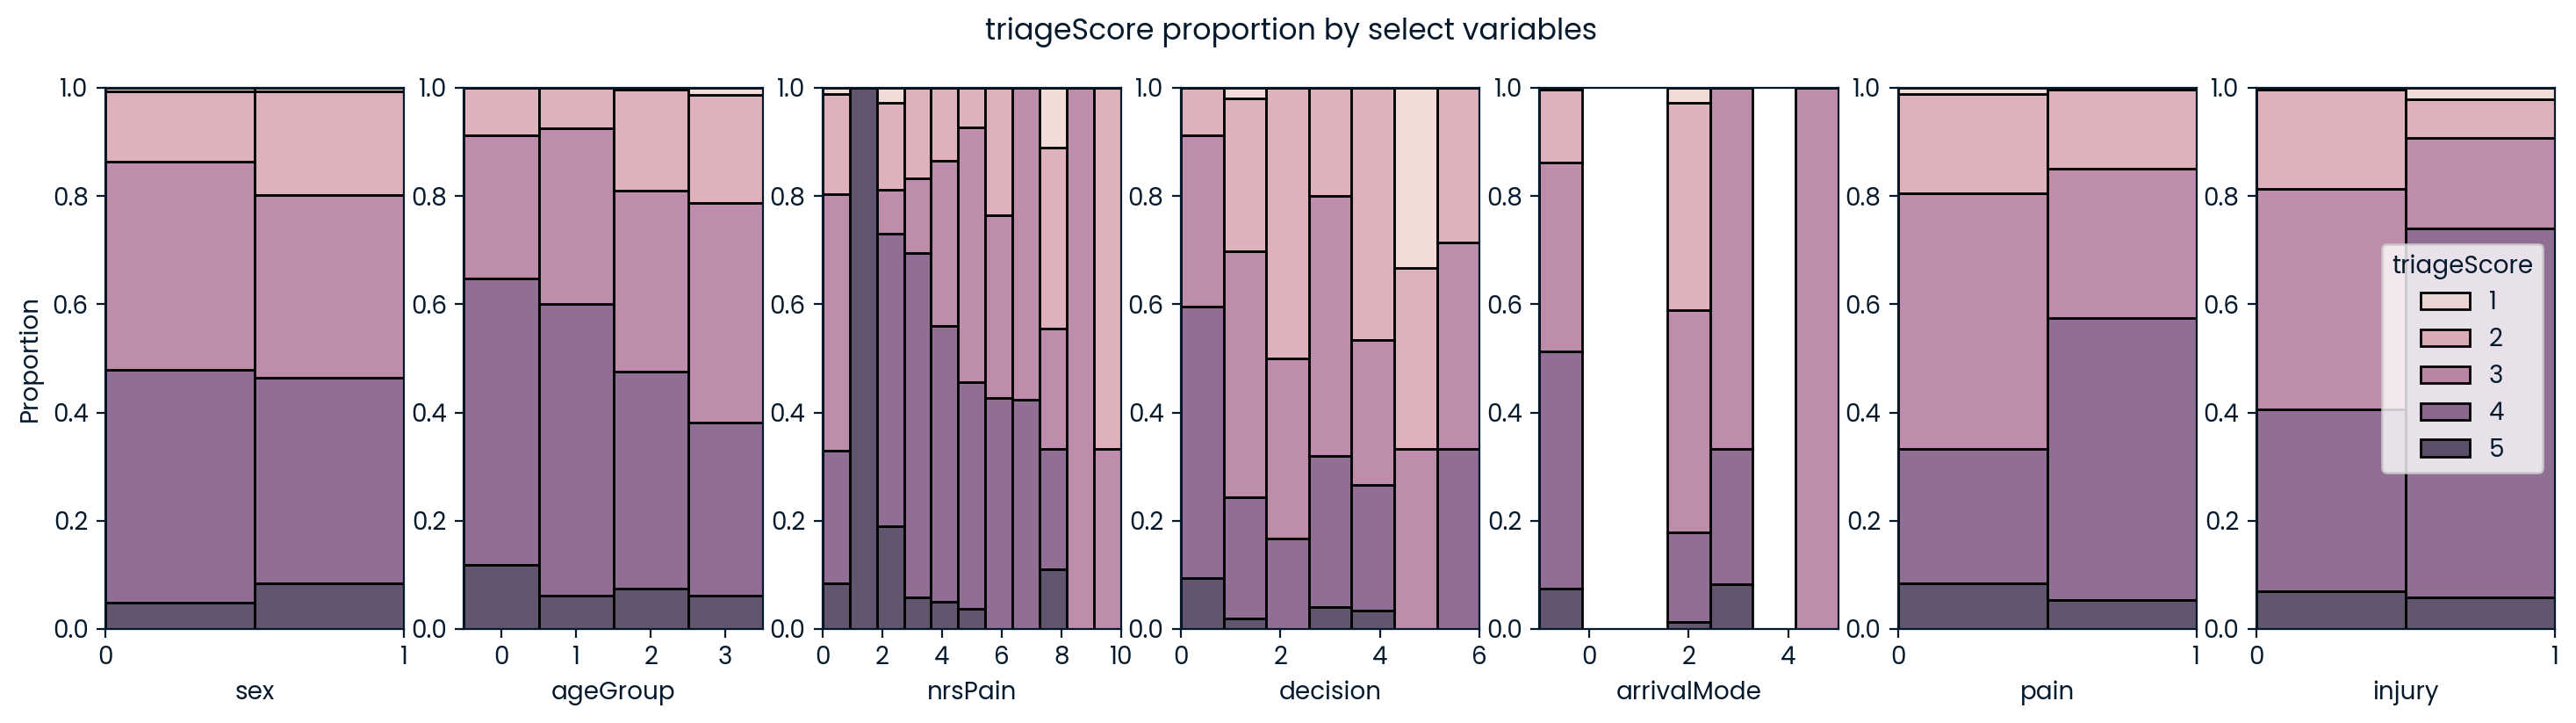

In [35]:
plt.clf()
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 7, figsize=(18, 4))
sns.histplot(dataTriage, x="sex", hue="triageScore", multiple="fill", bins=2, ax=ax0, legend=False)
sns.histplot(dataTriage, x="ageGroup", hue="triageScore", multiple="fill", ax=ax1, legend=False)
sns.histplot(dataTriage, x="nrsPain", hue="triageScore", multiple="fill", bins=11, ax=ax2, legend=False)
sns.histplot(dataTriage, x="decision", hue="triageScore", multiple="fill", bins=7, ax=ax3, legend=False)
sns.histplot(dataTriage, x="arrivalMode", hue="triageScore", multiple="fill", bins=7, ax=ax4,legend=False)
sns.histplot(dataTriage, x="pain", hue="triageScore", multiple="fill", bins=2, ax=ax5,legend=False)
sns.histplot(dataTriage, x="injury", hue="triageScore", multiple="fill", bins=2, ax=ax6)
ax0.set_xticks([0,1])
ax2.set_xticks([0,2,4,6,8,10])
ax5.set_xticks([0,1])
ax6.set_xticks([0,1])
ax0.set_xticklabels(ax0.get_xticklabels(), rotation= 0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 0)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation= 0)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation= 0)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation= 0)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation= 0)
ax0.set_ylabel('Proportion')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
fig.suptitle("triageScore proportion by select variables")
plt.show()

The dynamics of each of the column are laid out in the figure above. Results show that most of the cases reported are in KTAS 4 or 5 regardless of the age group. On the other hand, cases with numeric pain scale (`nrsPain`) of 9 and 10 have KTAS of 1 to 3. Below those pain scale values, the cases have KTAS of mostly 4 or 5. Finally, cases wherein patients reported pain (`pain`=0) and non-pain (`pain`=1) mostly have KTAS of 3 and 4, respectively.

# Modeling
Prior to ML modeling, columns `sbp` and `dbp` will undergo (natural) logarithmic transformation.

In [36]:
# transform sbp and dbp using ln(z)
for bp in ['sbp', 'dbp']:
    dataTriage[bp] = dataTriage[bp].apply(lambda z: math.log(z))

I then used `scikit-learn`'s `MLPClassifier` to construct the triage classifier; its hyperparameters will be optimized using Bayesian optimization. The library `bayesian-optimization` will be utilized for the latter. In the classifier, the `triageScore` will be predicted.

In [37]:
# The dataTriage dataframe is split into features and target variable
X = dataTriage.drop('triageScore', axis=1)
y = dataTriage['triageScore']


def optimize_mlp(hidden_layer_size, alpha, learning_rate_init):
    """
    Function to optimize MLPClassifier parameters using Bayesian Optimization.
    """
    hidden_layer_size = int(hidden_layer_size)
    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size,),
        activation='relu',
        solver='adam',
        alpha=alpha,
        learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    predictions = mlp.predict(X_test)
    return accuracy_score(y_test, predictions)

def bayesian_optimization_mlp(X, y, seedNum=42, n_iter=10, init_points=2):
    """
    Performs Bayesian Optimization to find the best MLPClassifier parameters.
    """
    global X_train, X_test, y_train, y_test # Make them globally available
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedNum)

    pbounds = {
        'hidden_layer_size': (10, 100),
        'alpha': (0.0001, 0.1),
        'learning_rate_init': (0.0001, 0.1)
    }

    optimizer = BayesianOptimization(
        f=optimize_mlp,
        pbounds=pbounds,
        random_state=42,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )

    best_params = optimizer.max['params']
    best_hidden_layer_size = int(best_params['hidden_layer_size'])
    best_alpha = best_params['alpha']
    best_learning_rate_init = best_params['learning_rate_init']

    best_mlp = MLPClassifier(
        hidden_layer_sizes=(best_hidden_layer_size,),
        activation='relu',
        solver='adam',
        alpha=best_alpha,
        learning_rate='adaptive',
        learning_rate_init=best_learning_rate_init,
        random_state=42
    )

    best_mlp.fit(X_train, y_train)
    return best_mlp, optimizer.max['target'], optimizer.max['params']


best_mlp_model, best_score, best_params = bayesian_optimization_mlp(X, y)

print("Best Score:", best_score)
print("Best Parameters:", best_params)

# test on X_test and y_test
predictions = best_mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on test set: {accuracy}")

|   iter    |  target   |   alpha   | hidden... | learni... |
-------------------------------------------------------------
| 1         | 0.4935    | 0.03752   | 95.56     | 0.07323   |
| 2         | 0.5484    | 0.05991   | 24.04     | 0.01568   |
| 3         | 0.5645    | 0.08748   | 25.35     | 0.01371   |
| 4         | 0.4935    | 0.04084   | 29.12     | 0.06923   |
| 5         | 0.5452    | 0.0923    | 20.16     | 0.09137   |
| 6         | 0.5258    | 0.03487   | 17.55     | 0.02201   |
| 7         | 0.5323    | 0.01333   | 60.47     | 0.05364   |
| 8         | 0.5226    | 0.0113    | 26.51     | 0.08151   |
| 9         | 0.5355    | 0.06872   | 21.64     | 0.04974   |
| 10        | 0.5484    | 0.01362   | 24.83     | 0.08833   |
| 11        | 0.5645    | 0.06827   | 23.1      | 0.04785   |
| 12        | 0.5516    | 0.07865   | 79.79     | 0.02515   |
Best Score: 0.5645161290322581
Best Parameters: {'alpha': 0.08748272823423854, 'hidden_layer_size': 25.35043402058666, 'learning_rat

I've managed to construct a triage classifier with a test set accuracy of about 56%. 

## Test on hypothetical cases
I tested the classifier on some use cases.

1. female (`sex`=0), 20-39 y/o (`ageGroup`=0), walk-in (`arrivalMode`=0), no injury (`injury`=0), no pain (`pain`=1), no nrs pain (`nrsPain`=0), `sbp`=122, `dbp`=82, `decision` = 0 (discharge)

In [38]:
# ensure the feature names and order match those used during model training
samplePatient0 = {
    'sex': 0, 
    'ageGroup': 1, 
    'arrivalMode': 0,
    'injury': 0, 
    'pain': 1, 
    'nrsPain': 0, 
    'sbp': np.log(122), 
    'dbp': np.log(82),
    'decision': 0
}

samplePatient0_df = pd.DataFrame([samplePatient0])
samplePatient0_df = samplePatient0_df[X_test.columns]

print(best_mlp_model.predict(samplePatient0_df)[0])

5


The model predicts that woman to be tagged under KTAS of 5 (non-urgent), which makes sense given her specifics.

2. male (`sex`=1), 45 y/o (`ageGroup`=2), arrived in a private car (`arrivalMode`=2), with injury (`injury`=1), in pain (`pain`=0), nrs pain of 6 (`nrsPain`=6), `sbp`=130, `dbp`=95, `decision` = 3 (ICU)

In [39]:
samplePatient1 = {
    'sex': 1, 
    'arrivalMode': 2,
    'injury': 1, 
    'pain': 0, 
    'nrsPain': 6, 
    'sbp': np.log(130), 
    'dbp': np.log(95),
    'ageGroup': 2, 
    'decision': 3
    
}

samplePatient1_df = pd.DataFrame([samplePatient1])
samplePatient1_df = samplePatient1_df[X_test.columns]

print(best_mlp_model.predict(samplePatient1_df)[0])


3


The model predicts that man to be tagged under KTAS of 3 (urgent)

3. female (`sex`=0), 70 y/o (`ageGroup`=4), arrived in a private car (`arrivalMode`=2), no injury (`injury`=0), in pain (`pain`=0), nrs pain of 8 (`nrsPain`=8), `sbp`=130, `dbp`=95, `decision` = 3 (ICU)


In [40]:
samplePatient2 = {
    'sex': 0, 
    'arrivalMode': 2,
    'injury': 0, 
    'pain': 0, 
    'nrsPain': 8, 
    'sbp': np.log(130), 
    'dbp': np.log(95),
    'ageGroup': 4, 
    'decision': 3
    
}

samplePatient2_df = pd.DataFrame([samplePatient2])
samplePatient2_df = samplePatient2_df[X_test.columns]

print(best_mlp_model.predict(samplePatient2_df)[0])


2


The model predicts that woman to be tagged under KTAS of 2 (emergent).

## Takeaways and recommendations
I've successfully constructed a triage classifier with a fair accuracy of ~56%. Improvements on the project include exploring other machine learning methods and adding in medical conditions (yes or no) as a feature. 

I sincerely hope that this project will highlight the incredible value of machine learning systems in aiding health workers with triage assessment, and that it will inspire both public and governmental action to improve healthcare access in underserved populations.


If you have questions and/or feedback, send them my way at jprmaulion[at]gmail[dot]com. Cheers!